# Autoencoder with Pytorch

In [2]:
import torch
import pickle
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch.nn.functional as inter
import torchvision.models as models
import seaborn as sb
import copy
from torchvision.transforms import ToTensor, ToPILImage

import os
from PIL import Image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import des données du problème**

In [4]:
dim_image = 100

torch.Size([10, 10000])


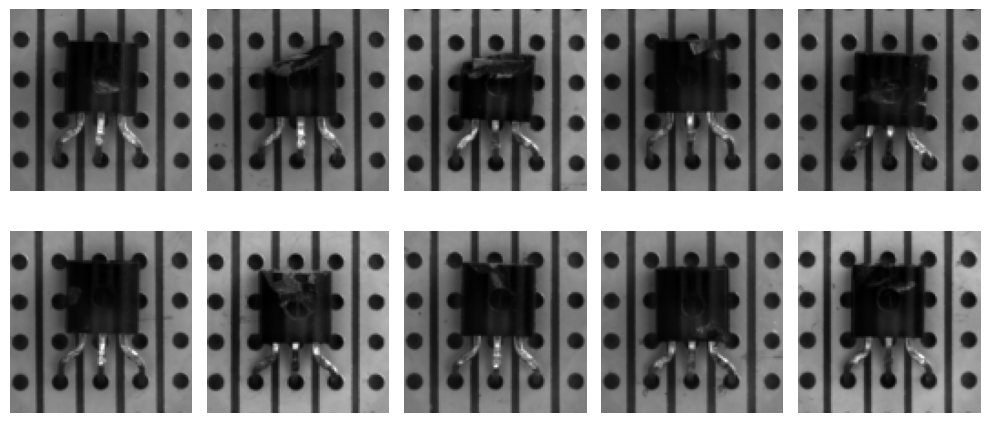

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image_rgb = Image.open(img_path)
        img_tensor = F.to_tensor(image_rgb)
        img_tensor_grey = F.rgb_to_grayscale(img_tensor, num_output_channels=1)
        img_resize = F.resize(img_tensor_grey, (dim_image, dim_image))
        img_squeezed = img_resize.squeeze(0)
        img_flat = img_squeezed.view(-1, dim_image**2)
        img_flat_squeezed = img_flat.squeeze(0)

        return img_flat_squeezed

# Définir les répertoires de train et test
train_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/train/good'
test_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/good'
test_cut_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/cut_lead'
test_bent_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/bent_lead'
test_damaged_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/damaged_case'
test_misplaced_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/misplaced'

# Créer les datasets
train_dataset = CustomDataset(train_dir)
test_dataset = CustomDataset(test_dir)
test_cut_dataset = CustomDataset(test_cut_dir)
test_bent_dataset = CustomDataset(test_bent_dir)
test_damaged_dataset = CustomDataset(test_damaged_dir)
test_misplaced_dataset = CustomDataset(test_misplaced_dir)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_damaged_loader = DataLoader(test_damaged_dataset, batch_size=10, shuffle=True)

for batch_idx, image in enumerate(test_damaged_loader):

        # Reshaping the image to (-1, 64*64)
        # plt.imshow(image.detach().numpy().reshape(64,64))
        #image = image.view(-1, 64*64)  # Utiliser .view() au lieu de .reshape()
        print(image.size())

        fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Créer une grille de 2x5
        axes = axes.flatten()  # Rendre les axes 2D en 1D pour les parcourir facilement

        for i in range(10):
          axes[i].imshow(image[i].reshape(dim_image,dim_image), cmap='gray')  # Afficher l'image i en niveaux de gris
          axes[i].axis('off')  # Supprimer les axes pour une meilleure visibilité

        plt.tight_layout()
        plt.show()
        break

# **Classes permettant l'optimisation et la création de modèles**

In [6]:
# Creating a PyTorch class
class AE(torch.nn.Module):

    def __init__(self, structure_layers):
        self.generation = 0
        self.optimizer = None
        self.data_downloader = None
        self.bottleneck = structure_layers[-1] # pour info
        self.nb_layers = len(structure_layers) # pour info
        # dans la structure, on définit à la fois le bottleneck et le nombre de layers
        self.structure_layers = structure_layers # structure_layers[0] supposé à 4096
        if structure_layers[0] != dim_image**2:
          structure_layers.insert(0, dim_image**2)
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        self.encoder = torch.nn.Sequential()

        if self.nb_layers > 1:
          self.encoder.append(torch.nn.Linear(structure_layers[0], structure_layers[1]))
          for i in range(1, self.nb_layers - 1):
            self.encoder.append(torch.nn.ReLU())
            self.encoder.append(torch.nn.Linear(structure_layers[i], structure_layers[i+1]))
        else :
          return "il faut au moins deux layers du type 4096,..."

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        self.decoder = torch.nn.Sequential(torch.nn.Linear(structure_layers[-1], structure_layers[-2]))

        if self.nb_layers > 2:
          for i in range(self.nb_layers - 2):
            self.decoder.append(torch.nn.ReLU())
            self.decoder.append(torch.nn.Linear(structure_layers[-i-2], structure_layers[-i-3]))
        self.decoder.append(torch.nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def optimize(self, loss_function, lr, batchsize, epochs):
        if self.optimizer is None:
            self.optimizer = optimizer_class(self, loss_function, lr, batchsize, epochs)
            self.generation += 1
        else:
          return("le modèle a déjà été optimisé avec des paramètres: il faut instancer un nouveau modèle")
        self.optimizer.optimize()
        print("The model is now optimized")

    def copy(self):
      return copy.deepcopy(self)

    def re_optimize(self, loss_function, lr, batchsize, epochs):
      if self.optimizer is None:
        return("le modèle n'a pas encore été optimisé")
      else:
        self.optimizer.loss_function = loss_function
        self.optimizer.lr = lr
        self.optimizer.batchsize = batchsize
        self.optimizer.epochs = epochs
        self.optimizer.optimize()
        self.generation += 1
        print(f'The model has been optimized {self.generation} times')


    def name(self):
      return f'AE_{self.optimizer.loss_function}_generation_{self.generation}_epochs_{self.optimizer.epochs}_lr_{self.optimizer.lr}_BS_{self.optimizer.batchsize}_Structure_{self.structure_layers}'

    def download_data(self):
      if self.optimizer is None:
        return("optimiser avant de charger les données")
      else:
        self.data_downloader = evaluate_download(self)
        self.data_downloader.sauvegarde_paires()


In [7]:
#création de la classe qui va optimiser avec l'optimiseur Adams seulement:

class optimizer_class:
  def __init__(self, model, loss_function, lr, batchsize, epochs):
    self.model = model
    self.loss_function = loss_function
    self.lr = lr
    self.optimizer = torch.optim.Adam(self.model.parameters(),
                             lr = self.lr,
                             weight_decay = 1e-8)
    self.batchsize = batchsize
    self.train_loader = DataLoader(train_dataset, self.batchsize, shuffle=True)
    self.epochs = epochs
    self.perte = []

  def infos(self):
    print("Model :", self.model)
    print("Loss function :", self.loss_function)
    print("Learning rate :", self.lr)
    print("Batch size :", self.batchsize)

  def optimize(self):
    #permet d'optimiser la fonction et de créer le tableau qui montre les loss au fil des itérations
    losses = []
    for epoch in range(self.epochs):
      for batch_idx, image in enumerate(self.train_loader):
        reconstructed = self.model(image)
        loss = self.loss_function(reconstructed, image)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        losses.append(loss.item())
      print(f'Epoch:{epoch}  Loss:{loss.item()}')
    self.perte = losses

  def plotting_grad_descents(self):
    plt.style.use('fivethirtyeight')
    title_txt = "loss function :", self.loss_function, "batch size :", self.batchsize, "learning rate :", self.lr, "epochs :", self.epochs
    plt.title(title_txt)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(self.perte)
    plt.show()



*texte en italique*# **Classes qui permettent l'évaluation des modèles**

In [8]:
#Classe qui permet d'évaluer les tableau tests

class evaluate_one_testset:
  def __init__(self, model):
    self.model = model
    self.optimizer = model.optimizer
    self.loss_function = self.optimizer.loss_function

  def evaluate_testset(self, test_loader):
    #calcule les loss sur l'ensemble d'un test_loader
    loss = []
    for (idx, image) in enumerate(test_loader):
      reconstructed = self.model(image)
      loss.append(self.loss_function(reconstructed, image).item())
    return loss


In [9]:
#Classe qui permet d'évaluer le modèle d'AE créé sur l'ensmble du testset

class creation_paires:
  def __init__(self, model, loss_function):
    self.model = model
    self.loss_function = model.optimizer.loss_function
    self.loss_good = []
    self.loss_bent = []
    self.loss_cut = []
    self.loss_damaged = []
    self.loss_misplaced = []
    self.loss_norm = []
    self.paire_good = []
    self.paire_bent = []
    self.paire_cut = []
    self.paire_damaged = []
    self.paire_misplaced = []
    self.paire_norm = []
    self.evaluate_testset = evaluate_one_testset(self.model)

  def calculte_losses_test(self):
    self.loss_good = self.evaluate_testset.evaluate_testset(test_dataset)
    self.loss_bent = self.evaluate_testset.evaluate_testset(test_bent_dataset)
    self.loss_cut = self.evaluate_testset.evaluate_testset(test_cut_dataset)
    self.loss_damaged = self.evaluate_testset.evaluate_testset(test_damaged_dataset)
    self.loss_misplaced = self.evaluate_testset.evaluate_testset(test_misplaced_dataset)
    self.loss_norm = self.evaluate_testset.evaluate_testset(train_dataset)

  def crée_paire(self):
    for i in range(len(self.loss_good)):
      self.paire_good.append([self.loss_good[i], 1])
    for i in range(len(self.loss_bent)):
      self.paire_bent.append([self.loss_bent[i], -1])
    for i in range(len(self.loss_cut)):
      self.paire_cut.append([self.loss_cut[i], -1])
    for i in range(len(self.loss_damaged)):
      self.paire_damaged.append([self.loss_damaged[i], -1])
    for i in range(len(self.loss_misplaced)):
      self.paire_misplaced.append([self.loss_misplaced[i], -1])
    for i in range(len(self.loss_norm)):
      self.paire_norm.append([self.loss_norm[i], 1])





In [10]:
#classe pour évaluer l'entiereté du modèle avec la ROC et la AUC,
#avec n_front frontières différentes pour l'anomalymap

class evaluate_download:
  def __init__(self, model):
    self.model = model
    self.optimizer = model.optimizer
    self.loss_function = self.optimizer.loss_function
    self.paires = creation_paires(self.model, self.loss_function)
    self.paires.calculte_losses_test()
    self.paires.crée_paire()

  def sauvegarde_paires(self):
    name = self.model.name()
    folder_path = f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name}'
    os.makedirs(folder_path, exist_ok=True)
    with open(f'{folder_path}/paire_good.pkl', 'wb') as file:
      pickle.dump(self.paires.paire_good, file)
    with open(f'{folder_path}/paire_bent.pkl', 'wb') as file:
      pickle.dump(self.paires.paire_bent, file)
    with open(f'{folder_path}/paire_misplaced.pkl', 'wb') as file:
      pickle.dump(self.paires.paire_misplaced, file)
    with open(f'{folder_path}/paire_cut.pkl', 'wb') as file:
      pickle.dump(self.paires.paire_cut, file)
    with open(f'{folder_path}/paire_damaged.pkl', 'wb') as file:
      pickle.dump(self.paires.paire_damaged, file)
    with open(f'{folder_path}/paire_norm.pkl', 'wb') as file:
      pickle.dump(self.paires.paire_norm, file)


class evaluate_whole_testset:
  def __init__(self, model, n_front):
    self.model = model
    self.optimizer = model.optimizer
    self.loss_function = self.optimizer.loss_function
    self.paires = creation_paires(self.model, self.loss_function)
    self.paires.calculte_losses_test()
    self.paires.crée_paire()
    self.n_front = n_front
    self.percent_good = []
    self.percent_an = []
    self.map_boundaries = [i/n_front for i in range(n_front+1)]

  def evaluation_boundary(self, paire, map_boundary):
    evaluation = []
    for i in range(len(paire)):
      evaluation.append(((2*int(paire[i][0] < map_boundary) - 1)*paire[i][1]+1)/2)
    return evaluation

  def evaluate_whole_testset(self):
    percent_an = []
    percent_good = []
    max_value = 0
    max_bound = self.map_boundaries[0]
    for boundary in self.map_boundaries:
      percent_evaluation_good = np.sum(self.evaluation_boundary(self.paires.paire_good, boundary))/len(self.paires.paire_good)
      percent_evaluation_an = np.sum(self.evaluation_boundary(self.paires.paire_bent + self.paires.paire_cut + self.paires.paire_damaged + self.paires.paire_misplaced, boundary))/len(self.paires.paire_bent + self.paires.paire_cut + self.paires.paire_damaged + self.paires.paire_misplaced)
      percent_good.append([percent_evaluation_good,boundary])
      percent_an.append([percent_evaluation_an,boundary])
      if percent_evaluation_good**2 + (percent_evaluation_an)**2 > max_value:
        max_bound = boundary
        max_value = percent_evaluation_good**2 + percent_evaluation_an**2
    self.max_bound = max_bound
    return percent_an, percent_good

  def evaluate_one_image(self, img_path):
    image_rgb = Image.open(img_path)
    img_tensor = F.to_tensor(image_rgb)
    img_tensor_grey = F.rgb_to_grayscale(img_tensor, num_output_channels=1)
    img_resize = F.resize(img_tensor_grey, (dim_image, dim_image))
    img_squeezed = img_resize.squeeze(0)
    img_flat = img_squeezed.view(-1, dim_image**2)
    img_flat_squeezed = img_flat.squeeze(0)
    evaluation = self.model(img_flat_squeezed)
    loss = self.loss_function(evaluation, img_flat_squeezed)
    if loss < self.max_bound:
      return "normal image"
    else:
      return "abnormal image"

  def plot_ROC(self):
    self.percent_good, self.percent_an = self.evaluate_whole_testset()
    percent_good, percent_an = self.percent_good, self.percent_an
    plt.plot(np.ones(len(percent_an))-np.array([i[0] for i in percent_an]), np.array([i[0] for i in percent_good]), label='ROC curve')
    plt.title('ROC curve')
    plt.xlabel('false positives')
    plt.ylabel('true positives')
    plt.legend()
    plt.show()

  def AUC(self):
    percent_good, percent_an = self.percent_good, self.percent_an
    auc = 1 - np.trapz(np.ones(len(percent_an))-np.array([i[0] for i in percent_an]), np.array([i[0] for i in percent_good]))
    return auc

# **Toutes les loss functions qui sont supportées par les classes**
On peut en initialiser d'autres si nécessaire

In [11]:
# Validation using MSE Loss function
loss_function_MSE = torch.nn.MSELoss()

loss_function_l1 = torch.nn.L1Loss()

# **Exemple pour comment créer et évaluer un modèle**
suivre l'exemple

Epoch:0  Loss:0.03865611553192139
Epoch:1  Loss:0.03561429679393768
Epoch:2  Loss:0.0320730023086071
Epoch:3  Loss:0.025011161342263222
Epoch:4  Loss:0.022272294387221336
Epoch:5  Loss:0.019724629819393158
Epoch:6  Loss:0.016729434952139854
Epoch:7  Loss:0.01730271987617016
Epoch:8  Loss:0.014272807165980339
Epoch:9  Loss:0.01366061344742775
The model is now optimized
Model : AE(
  (encoder): Sequential(
    (0): Linear(in_features=10000, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=10000, bias=True)
    (3): ReLU()
  )
)
Loss function : MSELoss()
Learning rate : 0.0001
Batch size : 10


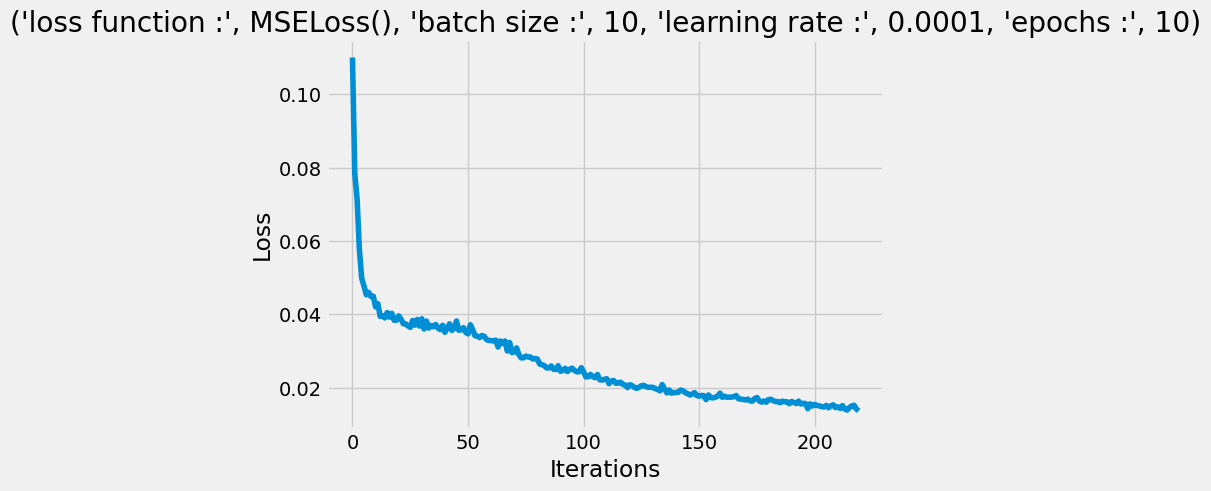

In [23]:
#les étapes pour faire un modèle et l'optimiser
#mais attention, un modèle ne peut être optimisé une seule fois!!

#initialiser le modèle:
model_MSE = AE([dim_image**2, 5000, 100])

#Voici comment optimiser un modèle (il y a deux loss_functions qui ont été initialisées):
model_MSE.optimize(loss_function_MSE, 1e-4, 10, 10)

model_MSE.download_data()
#Voilà comment l'évaluer ensuite:

model_MSE.optimizer.infos()

model_MSE.optimizer.plotting_grad_descents()

In [24]:
model_MSE.re_optimize(loss_function_MSE,1e-4,10,5)

Epoch:0  Loss:0.013247047550976276
Epoch:1  Loss:0.012364677153527737
Epoch:2  Loss:0.011668451130390167
Epoch:3  Loss:0.011055415496230125
Epoch:4  Loss:0.010735292918980122
The model has been optimized 2 times


In [25]:
model_MSE.download_data()

In [26]:
model_MSE.re_optimize(loss_function_MSE,1e-4,10,5)
model_MSE.download_data()

Epoch:0  Loss:0.009992547333240509
Epoch:1  Loss:0.009401509538292885
Epoch:2  Loss:0.009301537647843361
Epoch:3  Loss:0.00881530437618494
Epoch:4  Loss:0.008907843381166458
The model has been optimized 3 times


In [27]:
model_MSE.re_optimize(loss_function_MSE,1e-5,10,5)
model_MSE.download_data()

Epoch:0  Loss:0.008332725614309311
Epoch:1  Loss:0.007345135323703289
Epoch:2  Loss:0.0070120180025696754
Epoch:3  Loss:0.007441456895321608
Epoch:4  Loss:0.007362147327512503
The model has been optimized 4 times


In [28]:
model_MSE.re_optimize(loss_function_MSE,1e-4,10,5)
model_MSE.download_data()

Epoch:0  Loss:0.00681540509685874
Epoch:1  Loss:0.006918833125382662
Epoch:2  Loss:0.006744912825524807
Epoch:3  Loss:0.006341829895973206
Epoch:4  Loss:0.006282331887632608
The model has been optimized 5 times


In [29]:
model_MSE.re_optimize(loss_function_MSE,1e-4,10,5)
model_MSE.download_data()

Epoch:0  Loss:0.005613104440271854
Epoch:1  Loss:0.006235199049115181
Epoch:2  Loss:0.005666013807058334
Epoch:3  Loss:0.005440785549581051
Epoch:4  Loss:0.005193008575588465
The model has been optimized 6 times


In [30]:
model_MSE.re_optimize(loss_function_MSE,1e-4,10,10)
model_MSE.download_data()

Epoch:0  Loss:0.005163891240954399
Epoch:1  Loss:0.0052431137301027775
Epoch:2  Loss:0.0052857366390526295
Epoch:3  Loss:0.005065431352704763
Epoch:4  Loss:0.005252597853541374
Epoch:5  Loss:0.005358960945159197
Epoch:6  Loss:0.0050953892059624195
Epoch:7  Loss:0.004741330165416002
Epoch:8  Loss:0.004834810737520456
Epoch:9  Loss:0.004262829665094614
The model has been optimized 7 times


In [31]:
model_MSE.re_optimize(loss_function_MSE,1e-4,10,20)
model_MSE.download_data()

Epoch:0  Loss:0.004604327958077192
Epoch:1  Loss:0.0043774680234491825
Epoch:2  Loss:0.00440719909965992
Epoch:3  Loss:0.004549367818981409
Epoch:4  Loss:0.004588795360177755
Epoch:5  Loss:0.004192522261291742
Epoch:6  Loss:0.0042119985446333885
Epoch:7  Loss:0.003966022282838821
Epoch:8  Loss:0.0041468823328614235
Epoch:9  Loss:0.004104052670300007
Epoch:10  Loss:0.004160331562161446
Epoch:11  Loss:0.0037380983121693134
Epoch:12  Loss:0.003953798208385706
Epoch:13  Loss:0.003488146001473069
Epoch:14  Loss:0.003990726079791784
Epoch:15  Loss:0.00359048368409276
Epoch:16  Loss:0.003907485399395227
Epoch:17  Loss:0.0035050460137426853
Epoch:18  Loss:0.003690276062116027
Epoch:19  Loss:0.0035307975485920906
The model has been optimized 8 times


In [32]:
model_MSE.re_optimize(loss_function_MSE,1e-5,10,5)
model_MSE.download_data()

Epoch:0  Loss:0.0034568163100630045
Epoch:1  Loss:0.003442005952820182
Epoch:2  Loss:0.0037235168274492025
Epoch:3  Loss:0.003449406009167433
Epoch:4  Loss:0.003594756592065096
The model has been optimized 9 times


In [33]:
model_l1 = AE([dim_image**2, 5000, 100])

#Voici comment optimiser un modèle (il y a deux loss_functions qui ont été initialisées):
model_l1.optimize(loss_function_l1, 1e-4, 10, 10)

Epoch:0  Loss:0.1335013061761856
Epoch:1  Loss:0.1204671710729599
Epoch:2  Loss:0.12129448354244232
Epoch:3  Loss:0.11342676728963852
Epoch:4  Loss:0.09922222048044205
Epoch:5  Loss:0.09501262754201889
Epoch:6  Loss:0.09386951476335526
Epoch:7  Loss:0.08696293830871582
Epoch:8  Loss:0.08259876817464828
Epoch:9  Loss:0.07936526834964752
The model is now optimized


In [34]:
model_l1.download_data()

In [35]:
model_l1.re_optimize(loss_function_l1, 1e-4, 10, 10)
model_l1.download_data()

Epoch:0  Loss:0.0866929367184639
Epoch:1  Loss:0.07925976067781448
Epoch:2  Loss:0.07571395486593246
Epoch:3  Loss:0.06935151666402817
Epoch:4  Loss:0.0754765123128891
Epoch:5  Loss:0.06685099750757217
Epoch:6  Loss:0.0670611634850502
Epoch:7  Loss:0.0673077180981636
Epoch:8  Loss:0.0664241686463356
Epoch:9  Loss:0.06587694585323334
The model has been optimized 2 times


In [36]:
model_l1.re_optimize(loss_function_l1, 1e-5, 10, 10)
model_l1.download_data()

Epoch:0  Loss:0.06374689191579819
Epoch:1  Loss:0.05906574800610542
Epoch:2  Loss:0.05777589604258537
Epoch:3  Loss:0.05868447944521904
Epoch:4  Loss:0.057133838534355164
Epoch:5  Loss:0.05740895867347717
Epoch:6  Loss:0.05670273303985596
Epoch:7  Loss:0.05758699029684067
Epoch:8  Loss:0.05348857119679451
Epoch:9  Loss:0.05159396305680275
The model has been optimized 3 times


In [37]:
model_l1.re_optimize(loss_function_l1, 1e-5, 10, 5)
model_l1.download_data()

Epoch:0  Loss:0.055410392582416534
Epoch:1  Loss:0.05546702817082405
Epoch:2  Loss:0.04909700155258179
Epoch:3  Loss:0.046106837689876556
Epoch:4  Loss:0.052215490490198135
The model has been optimized 4 times


In [1]:
model_l1_copy= [model_l1.copy() for k in range(5)]


NameError: name 'model_l1' is not defined

In [40]:
for k in range(5):
  model_l1_copy[k].re_optimize(loss_function_l1, 1e-5, 10, k+1)
  model_l1_copy[k].download_data()

AttributeError: 'generator' object has no attribute 're_optimize'

In [ ]:
evaluation = evaluate_whole_testset(model_MSE, 1000)

evaluation.evaluate_whole_testset()



([[1.0, 0.0],
  [1.0, 0.001],
  [1.0, 0.002],
  [1.0, 0.003],
  [1.0, 0.004],
  [1.0, 0.005],
  [1.0, 0.006],
  [1.0, 0.007],
  [1.0, 0.008],
  [1.0, 0.009],
  [1.0, 0.01],
  [1.0, 0.011],
  [1.0, 0.012],
  [1.0, 0.013],
  [1.0, 0.014],
  [1.0, 0.015],
  [1.0, 0.016],
  [1.0, 0.017],
  [1.0, 0.018],
  [1.0, 0.019],
  [1.0, 0.02],
  [1.0, 0.021],
  [1.0, 0.022],
  [1.0, 0.023],
  [1.0, 0.024],
  [1.0, 0.025],
  [1.0, 0.026],
  [1.0, 0.027],
  [1.0, 0.028],
  [0.975, 0.029],
  [0.925, 0.03],
  [0.825, 0.031],
  [0.675, 0.032],
  [0.525, 0.033],
  [0.475, 0.034],
  [0.325, 0.035],
  [0.25, 0.036],
  [0.225, 0.037],
  [0.2, 0.038],
  [0.15, 0.039],
  [0.15, 0.04],
  [0.15, 0.041],
  [0.15, 0.042],
  [0.15, 0.043],
  [0.15, 0.044],
  [0.125, 0.045],
  [0.125, 0.046],
  [0.125, 0.047],
  [0.075, 0.048],
  [0.05, 0.049],
  [0.05, 0.05],
  [0.05, 0.051],
  [0.05, 0.052],
  [0.05, 0.053],
  [0.05, 0.054],
  [0.05, 0.055],
  [0.05, 0.056],
  [0.025, 0.057],
  [0.0, 0.058],
  [0.0, 0.059],
  [0.0

In [ ]:
evaluation.max_bound

0.037

In [ ]:
evaluation.evaluate_one_image('/content/drive/MyDrive/EA_MAP/transistor/transistor/test/damaged_case/008.png')

'normal image'

In [ ]:
models_bottleneck = [AE([4096, 250, 10+5*i]) for i in range(10)]

for i in range(10):
  models_bottleneck[i].optimize(loss_function_MSE, 1e-3, 7, 10)
  models_bottleneck[i].download_data()

Epoch:0  Loss:0.03743338584899902
Epoch:1  Loss:0.037982627749443054
Epoch:2  Loss:0.03599877282977104
Epoch:3  Loss:0.03508205711841583
Epoch:4  Loss:0.0308509673923254
Epoch:5  Loss:0.030532924458384514
Epoch:6  Loss:0.02809111773967743
Epoch:7  Loss:0.027613608166575432
Epoch:8  Loss:0.023924531415104866
Epoch:9  Loss:0.0228701401501894
The model is now optimized
Epoch:0  Loss:0.03744244575500488
Epoch:1  Loss:0.03587917611002922
Epoch:2  Loss:0.03310714289546013
Epoch:3  Loss:0.028385693207383156
Epoch:4  Loss:0.027537094429135323
Epoch:5  Loss:0.025009511038661003
Epoch:6  Loss:0.025072237476706505
Epoch:7  Loss:0.022429203614592552
Epoch:8  Loss:0.020718568935990334
Epoch:9  Loss:0.020338864997029305
The model is now optimized
Epoch:0  Loss:0.03841244801878929
Epoch:1  Loss:0.03360554203391075
Epoch:2  Loss:0.030469955876469612
Epoch:3  Loss:0.030468957498669624
Epoch:4  Loss:0.02645859681069851
Epoch:5  Loss:0.02499775029718876
Epoch:6  Loss:0.024583974853157997
Epoch:7  Loss:0.

Model : AE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
    (3): Sigmoid()
  )
)
Loss function : MSELoss()
Learning rate : 0.001
Batch size : 10


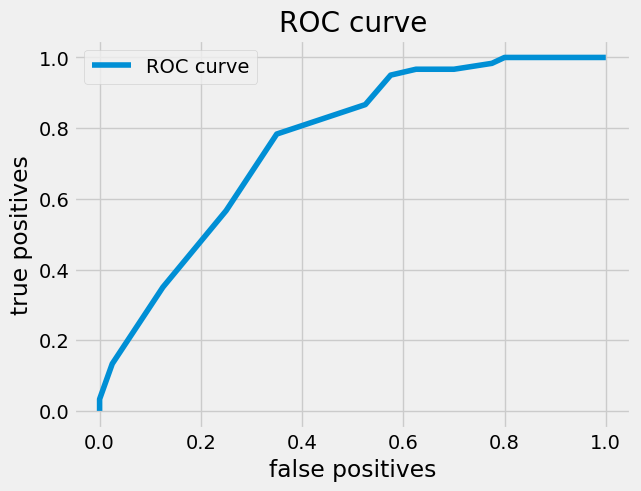

AUC : 0.7591666666666667


In [ ]:
#Voila comment évaluer un modèle, toujours avec l'exemple model_MSE

#affichage des paramètre ayant menés à ce modèle
model_MSE.optimizer.infos()

#initialiser la classe qui effectue l'évaluation du modèle créé
evaluate_whole_testset_MSE = evaluate_whole_testset(model_MSE, 1000)

#sauvegarder toutes les données:


#affichage de la ROC et du AUC
evaluate_whole_testset_MSE.plot_ROC()
print("AUC :", evaluate_whole_testset_MSE.AUC())

# **A partir d'ici on commence les tests**

In [ ]:
model_good = AE([4096,2000,500,64])

model_good.optimize(loss_function_MSE, 1e-3, 7, 10)

model_good.download_data()

Epoch:0  Loss:0.029740622267127037
Epoch:1  Loss:0.029282376170158386
Epoch:2  Loss:0.027616748586297035
Epoch:3  Loss:0.02862734906375408
Epoch:4  Loss:0.026318321004509926
Epoch:5  Loss:0.02567722462117672
Epoch:6  Loss:0.021065859124064445
Epoch:8  Loss:0.019163032993674278
Epoch:9  Loss:0.017826000228524208
The model is now optimized


In [ ]:
model_good_bis = model_good.copy()



In [ ]:
model_good_bis.re_optimize(loss_function_MSE,1e-4,7,5)



Epoch:0  Loss:0.018880045041441917
Epoch:1  Loss:0.01798262633383274
Epoch:2  Loss:0.017510930076241493
Epoch:3  Loss:0.01807996816933155
Epoch:4  Loss:0.016428181901574135


AttributeError: 'AE' object has no attribute 'nb_optimize'

In [ ]:
model_good_bis.download_data()


In [ ]:
model_good_bis_bis = model_good_bis.copy()

model_good_bis_bis.re_optimize(loss_function_MSE,1e-5,6,8)

Epoch:0  Loss:0.015228052623569965
Epoch:1  Loss:0.015712833032011986
Epoch:2  Loss:0.013940829783678055
Epoch:3  Loss:0.01414588000625372
Epoch:4  Loss:0.0138761131092906
Epoch:5  Loss:0.013742896728217602
Epoch:6  Loss:0.011490755714476109
Epoch:7  Loss:0.010913149453699589


AttributeError: 'AE' object has no attribute 'nb_optimize'

In [ ]:
model_good_bis_bis.download_data()

In [ ]:
model_good_bis_bis_bis = model_good_bis_bis.copy()

model_good_bis_bis_bis.re_optimize(loss_function_MSE,1e-6,6,8)

Epoch:0  Loss:0.010580737143754959
Epoch:1  Loss:0.009538322687149048
Epoch:2  Loss:0.010007239878177643
Epoch:3  Loss:0.009747017174959183
Epoch:4  Loss:0.009198438376188278
Epoch:5  Loss:0.008962235413491726
Epoch:6  Loss:0.009569480083882809
Epoch:7  Loss:0.008211410604417324


AttributeError: 'AE' object has no attribute 'nb_optimize'

In [ ]:
model_good_bis_bis_bis.download_data()

In [ ]:
model_test = AE([4096,2048,1024,512,256,128,64])

model_test.optimize(loss_function_MSE, 1e-3, 7, 10)

model_test.download_data()

Epoch:0  Loss:0.03775164112448692
Epoch:1  Loss:0.041293997317552567
Epoch:2  Loss:0.03892106935381889
Epoch:3  Loss:0.03896257281303406
Epoch:4  Loss:0.03895358368754387
Epoch:5  Loss:0.03926039859652519
Epoch:6  Loss:0.038863155990839005
Epoch:7  Loss:0.04174244776368141
Epoch:8  Loss:0.03934605419635773
Epoch:9  Loss:0.03569557145237923
The model is now optimized


In [ ]:
model_test_bis = model_test.copy()

model_test_bis.re_optimize(loss_function_MSE,1e-4,7,5)

Epoch:0  Loss:0.03685609996318817
Epoch:1  Loss:0.039663612842559814
Epoch:2  Loss:0.03885088488459587
Epoch:3  Loss:0.03944094479084015
Epoch:4  Loss:0.034333471208810806
The model has been optimized 2 times


In [ ]:
model_test_bis.download_data()

In [ ]:
model_test_bis_bis = model_test_bis.copy()

model_test_bis_bis.re_optimize(loss_function_MSE,1e-5,6,8)

model_test_bis_bis.download_data()

Epoch:0  Loss:0.03181140497326851
Epoch:1  Loss:0.0331052802503109
Epoch:2  Loss:0.029500668868422508
Epoch:3  Loss:0.028900928795337677
Epoch:4  Loss:0.032571759074926376
Epoch:5  Loss:0.028765389695763588
Epoch:6  Loss:0.028403552249073982
Epoch:7  Loss:0.02869805134832859
The model has been optimized 3 times
